In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/differential_learning/gait_merged_dataset.csv')

In [ ]:
import numpy as np

# Step 1: Extract only numerical features
non_feature_cols = ['subject', 'trial', 'force_column']
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# Step 2: Ensure trials are sorted correctly per subject
df['trial_num'] = df['trial'].str.extract(r'_(\d+)_').astype(int)
df_sorted = df.sort_values(by=['subject', 'trial_num'])

# Step 3: Group by subject and extract trial features
subjects = df_sorted['subject'].unique()
num_subjects = len(subjects)
num_trials = 20
feature_dim = len(feature_cols)

# Step 4: Create (num_subjects, num_trials, feature_dim) array
subject_trial_tensor = np.zeros((num_subjects, num_trials, feature_dim), dtype=np.float32)
valid_subjects = []

for i, subject in enumerate(subjects):
    subject_df = df_sorted[df_sorted['subject'] == subject]
    if len(subject_df) == num_trials:
        subject_trial_tensor[i] = subject_df[feature_cols].values
        valid_subjects.append(subject)

# Report the final shape and number of valid subjects
subject_trial_tensor.shape, len(valid_subjects)

((57, 20, 495), 40)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

flat = subject_trial_tensor.reshape(-1, 495)
scaler = MinMaxScaler()
flat_scaled = scaler.fit_transform(flat)
gait_tensor = flat_scaled.reshape(subject_trial_tensor.shape[0], 20, 495)

# Multivariate DTW Distance Function

In [ ]:
! pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542086 sha256=1fe4d6f929f8c1675710b3db5503dec253297de5a7e442a2738ca87b1617d0b4
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [ ]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def compute_dtw_distance(trial_a, trial_b):
    """
    Computes multivariate DTW distance between two trials.
    Each trial is a 1D or 2D feature array of shape (features,) or (time, features)
    We reshape to (timesteps, features=1) if needed to align them.
    """
    # Ensure shape is (T, D)
    if trial_a.ndim == 1:
        trial_a = trial_a.reshape(-1, 1)
    if trial_b.ndim == 1:
        trial_b = trial_b.reshape(-1, 1)

    distance, _ = fastdtw(trial_a, trial_b, dist=euclidean)
    return distance

# DTW Learning Distance Curve

In [ ]:
def dtw_learning_curve(subject_trials):
    """
    Computes DTW between consecutive trials to better capture progression.
    """
    distances = []
    for i in range(1, len(subject_trials)):
        ref_trial = subject_trials[i - 1]
        current_trial = subject_trials[i]
        #print(f"Trial {i}: Mean={subject_trials[i].mean()}, Std={subject_trials[i].std()}")
        distances.append(compute_dtw_distance(ref_trial, current_trial))
    return distances

# Apply Across All Subjects

In [ ]:
def dtw_all_subjects(tensor_3d):
    """
    tensor_3d: (N, 20, D) - subjects x trials x features
    Returns:
        List of dicts: subject_id, final_dtw (1 vs 20), dtw_curve
    """
    results = []
    for i in range(tensor_3d.shape[0]):
        subject = tensor_3d[i]
        curve = dtw_learning_curve(subject)
        results.append({
            "subject_id": i + 1,
            "final_dtw": curve[-1],
            "dtw_curve": curve
        })
    return results

# Rank + Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_dtw_curve(subject_result):
    plt.plot(range(2, 21), subject_result['dtw_curve'], marker='o')
    plt.title(f"DTW Curve: Subject {subject_result['subject_id']}")
    plt.xlabel("Trial Number")
    plt.ylabel("DTW Distance from Trial 1")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run DTW Analysis Across All Subjects

In [ ]:
dtw_results = dtw_all_subjects(gait_tensor)

# Rank Top/Bottom Subjects by Final DTW Distance

In [ ]:
import pandas as pd

dtw_df = pd.DataFrame(dtw_results)
top_dtw = dtw_df.nlargest(5, 'final_dtw')   # Subjects who evolved most
bottom_dtw = dtw_df.nsmallest(5, 'final_dtw')  # Subjects who barely changed

print("🧠 Top Learners (DTW):\n", top_dtw)
print("\n💤 Least Changed Subjects:\n", bottom_dtw)

🧠 Top Learners (DTW):
     subject_id  final_dtw                                          dtw_curve
24          25  60.617291  [58.42773268860765, 43.68986994307488, 69.3796...
17          18  56.553160  [39.002931823488325, 45.16649515856989, 73.593...
16          17  54.448453  [27.758538010064512, 24.89621446467936, 34.331...
26          27  53.872889  [44.512192335445434, 22.410561016760767, 52.01...
18          19  53.092809  [31.51375644141808, 65.5396993434988, 45.93183...

💤 Least Changed Subjects:
    subject_id  final_dtw                                          dtw_curve
1           2        0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2           3        0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4           5        0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5           6        0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7           8        0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


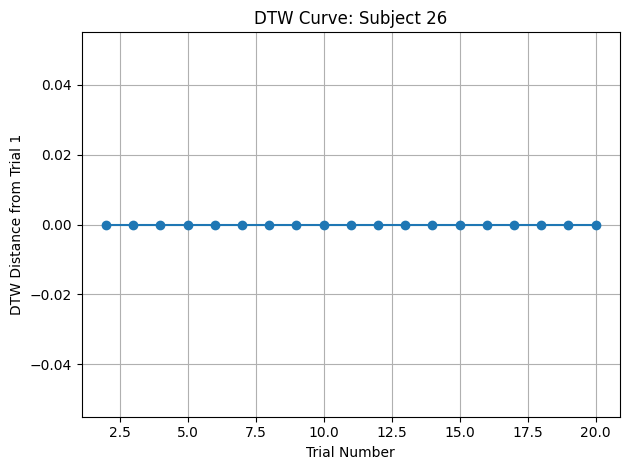

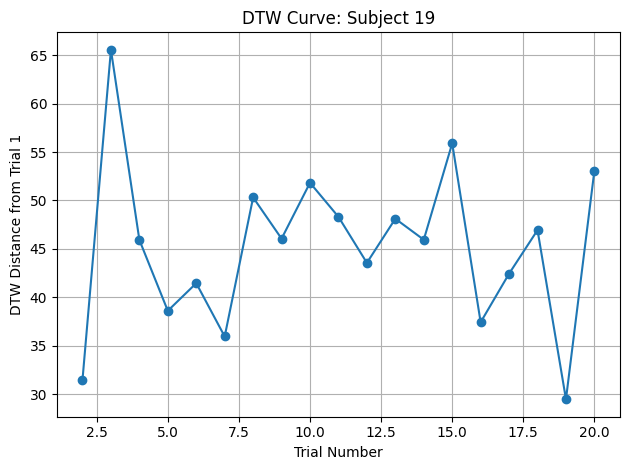

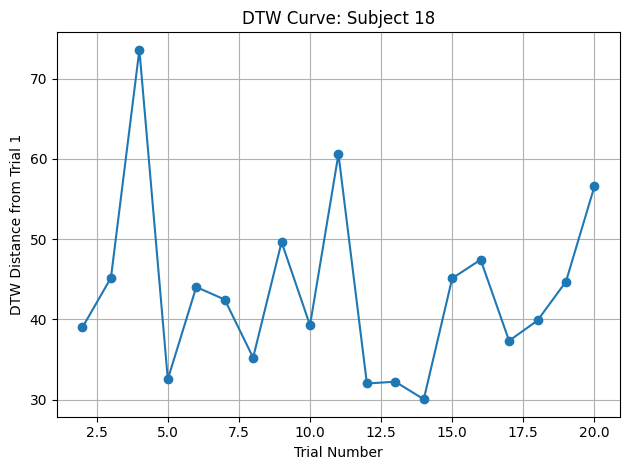

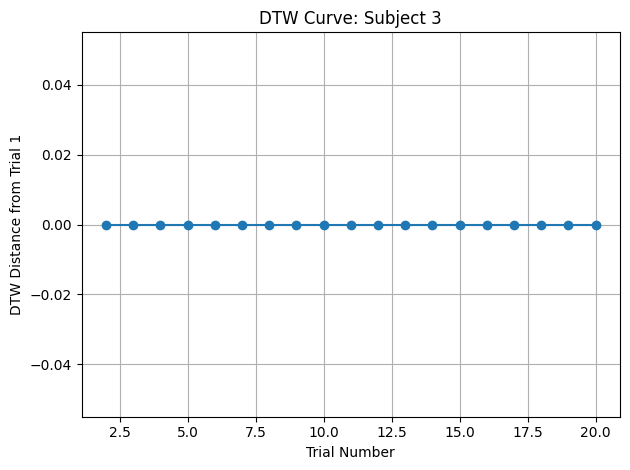

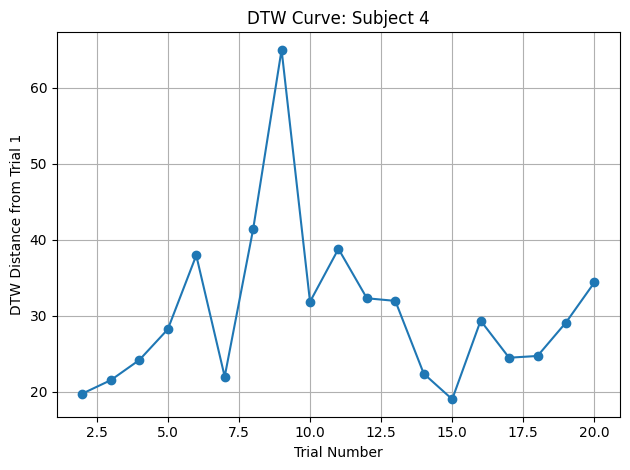

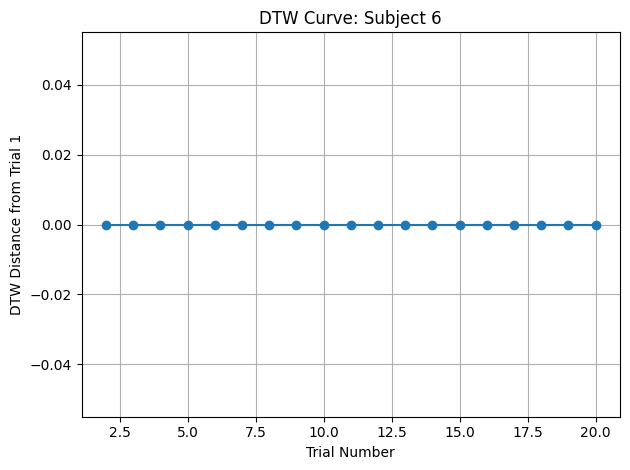

In [ ]:
# Plot top 3
for i in top_dtw['subject_id'].values[:3]:
    plot_dtw_curve(dtw_results[i])

# Plot bottom 3
for i in bottom_dtw['subject_id'].values[:3]:
    plot_dtw_curve(dtw_results[i])

In [ ]:
import pandas as pd

dtw_df = pd.DataFrame(dtw_results)

In [ ]:
dtw_df.to_csv("/content/drive/MyDrive/differential_learning/subject_dtw_scores.csv", index=False)

In [ ]:
dtw_df

,subject_id,final_dtw,dtw_curve
0,1,30.942326,"[22.044224474928342, 18.935448204400018, 20.67..."
1,2,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,34.392516,"[19.789006422273815, 21.55911359912716, 24.202..."
4,5,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,6,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,7,40.854466,"[48.75445198849775, 32.946131565840915, 25.244..."
7,8,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,9,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,10,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
